# [ML 학습 정리] 사이킷런을 이용한 분류 모델 (로지스틱회귀)

In [1]:
from IPython.display import Image

## 로지스틱회귀 모델을 들어가기 앞서 오즈비와 시그모이드에 대해 알아야 한다!
- 오즈(Odds) : 특정 이벤트가 발생할 확률 (p)
- 오즈비 : p/(1-p)
- 로짓함수 : 오즈비에 로그함수(자연로그, ln)를 취해 표현


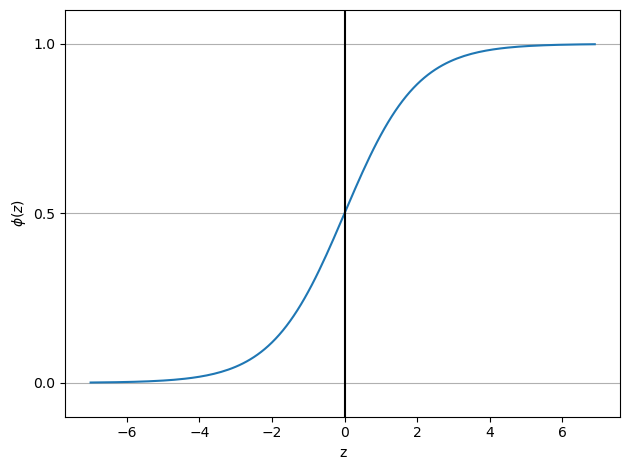

In [2]:
import matplotlib.pyplot as plt
import numpy as np


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y 축의 눈금과 격자선
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
# plt.savefig('images/03_02.png', dpi=300)
plt.show()

## 아달린과 로지스틱 회귀의 차이점 - 활성화 함수

In [3]:
Image(url='https://git.io/Jtm22', width=500) 

## 로지스틱 비용 함수의 가중치 학습하기

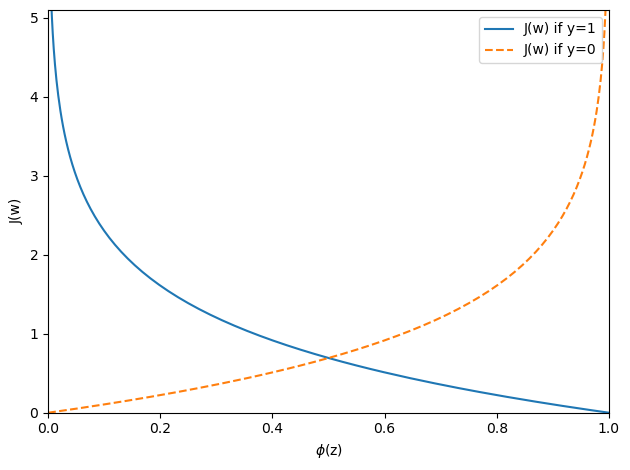

-> y=1,0인 샘플을 정확히 예측하면 비용함수 J(w)가 0에 가까워지는 것을 볼 수 있고,
   예측이 잘못되면 비용이 무한대가 된다.


In [5]:
def cost_1(z):
    return - np.log(sigmoid(z))


def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('images/03_04.png', dpi=300)
plt.show() 
print("-> y=1,0인 샘플을 정확히 예측하면 비용함수 J(w)가 0에 가까워지는 것을 볼 수 있고,")
print("   예측이 잘못되면 비용이 무한대가 된다.")

In [8]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:,[2,3]]
y = iris.target
print('클래스 레이블 : ', np.unique(y))  

클래스 레이블 :  [0 1 2]


In [11]:
# 훈련/테스트 셋 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# 데이터셋 분할 전 무작위로 섞기위해 난수 생성기를 이용하는데, random_state 매개변수를 고정하면 실행 결과를 다시 재현할 수 있음
# stratify 계층화 기능을 사용하여 훈련/테스트 셋의 클래스 레이블 비율을 동일하게 만듦

In [12]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [16]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X,y,classifier, resolution=0.02,test_idx=None):
    #마커와 컬러맵 설정
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','grey','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    #결정 경계 그리기
    x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1
    x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution),
                          )
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1,xx2,Z,alpha=0.3,cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y == cl, 0],
                    y = X[y == cl, 1],
                    alpha = 0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')
      
    # 테스트 샘플 부각
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:,0],X_test[:,1],
                    c='', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='test set')
    
                                          

In [17]:
class LogisticRegressionGD(object):
    """경사 하강법을 사용한 로지스틱 회귀 분류기

    매개변수
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드

    속성
    -----------
    w_ : 1d-array
      학습된 가중치
    cost_ : list
      에포크마다 누적된 로지스틱 비용 함수 값

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """훈련 데이터 학습

        매개변수
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          n_samples 개의 샘플과 n_features 개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃값

        반환값
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # 오차 제곱합 대신 로지스틱 비용을 계산합니다.
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """로지스틱 시그모이드 활성화 계산"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # 다음과 동일합니다.
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

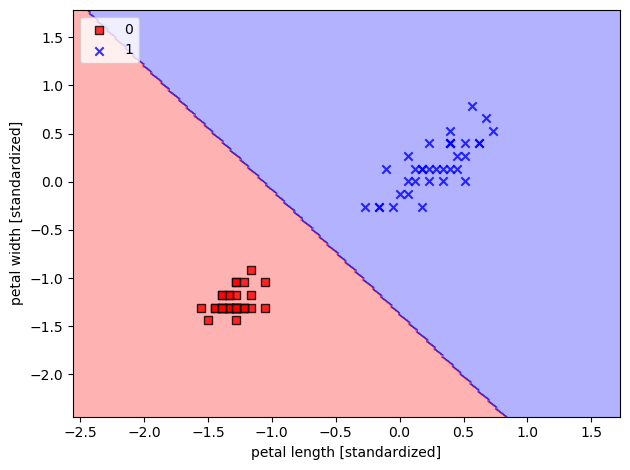

In [18]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('images/03_05.png', dpi=300)
plt.show()